# Claim Frequency Modeling

#### What are the benefits of machine learning techniques for car insurance pricing? To answer this question, the claims frequency for a large French motor third party liability insurance portfolio is modeled and predicted. In a first classical approach, generalized linear models (GLM) are used and a benchmark is defined. Then, the gradient tree boosting machines (GBM) CatBoost, LightGBM and XGBoost, known for their prediction accuracy, are applied with and without monotone constraints and the explainability of the models is investigated. Finally, artificial neural networks, including the combined actuarial neural network (CANN), are used. It is shown that both neural networks and GBMs can at least be used to improve classical models. Furthermore, the GBMs are shown to be the superior forecasting models, even when monotone constraints are applied to account for plausible tariff structures.

# Prepare the data

In [3]:
## Imports

import os
os.environ["PYTHONWARNINGS"] = "ignore"

seed = 23

import subprocess
import time
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from scipy.stats import uniform, loguniform
# pip install pyarrow_hotfix # due to PyArrow security vulnerability 
import pyarrow_hotfix


# Explain the things done by AI
import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG, Image

sns.set(rc = {"figure.figsize": (12, 7)})
sns.set_theme()

# Import Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Tuning of model
from sklearn.model_selection import GridSearchCV


In [8]:
# Read the frequency data

df_raw = pd.read_csv("Dataset/freMTPL2freq.csv")

df_raw.IDpol = df_raw.IDpol.astype(int)
df_raw["Exposure"] = np.minimum(1, df_raw.Exposure)
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)


# Read the Another fold

df_folds = pd.read_csv("Dataset/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int)

df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')


print('Rows and columns: ', df.shape[0], ' x ', df.shape[1])
print("\nCheck the end of the dataset")
df.tail(6)

Rows and columns:  678013  x  13

Check the end of the dataset


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold
678007,6114325,0,0.005479,E,6,4,40,68,B12,Regular,2733,R93,2
678008,6114326,0,0.002740,E,4,0,54,50,B12,Regular,3317,R93,3
678009,6114327,0,0.002740,E,4,0,41,95,B12,Regular,9850,R11,5
678010,6114328,0,0.002740,D,6,2,45,50,B12,Diesel,1323,R82,5
678011,6114329,0,0.002740,B,4,0,60,50,B12,Regular,95,R26,3
678012,6114330,0,0.002740,B,7,6,29,54,B12,Diesel,65,R72,5


In [6]:
df_raw.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [10]:
# Take claim number from severity file

sev = pd.read_csv("Dataset/freMTPL2sev.csv")

sev["ClaimNb"] = 1
sev_agg = sev.groupby("IDpol").sum("ClaimNb").drop(columns = ["ClaimAmount"])

sev_agg.head(5)


,ClaimNb
IDpol,
139,1
190,1
414,1
424,2
463,1


In [11]:
df = pd.merge(df.drop(columns = ['ClaimNb']), sev_agg, on = 'IDpol', how = 'left').fillna(0)

df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

df.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,2.997021,0.038945
std,1.641783e+06,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,1.413916,0.205026
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,1.000000,0.000000
25%,1.157951e+06,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,2.000000,0.000000
50%,2.272152e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,3.000000,0.000000
75%,4.046274e+06,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,4.000000,0.000000
max,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,5.000000,4.000000


In [14]:
df.isna().sum()

IDpol         0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
fold          0
ClaimNb       0
dtype: int64

<Axes: title={'center': 'Histogram of the exposure'}, ylabel='Frequency'>

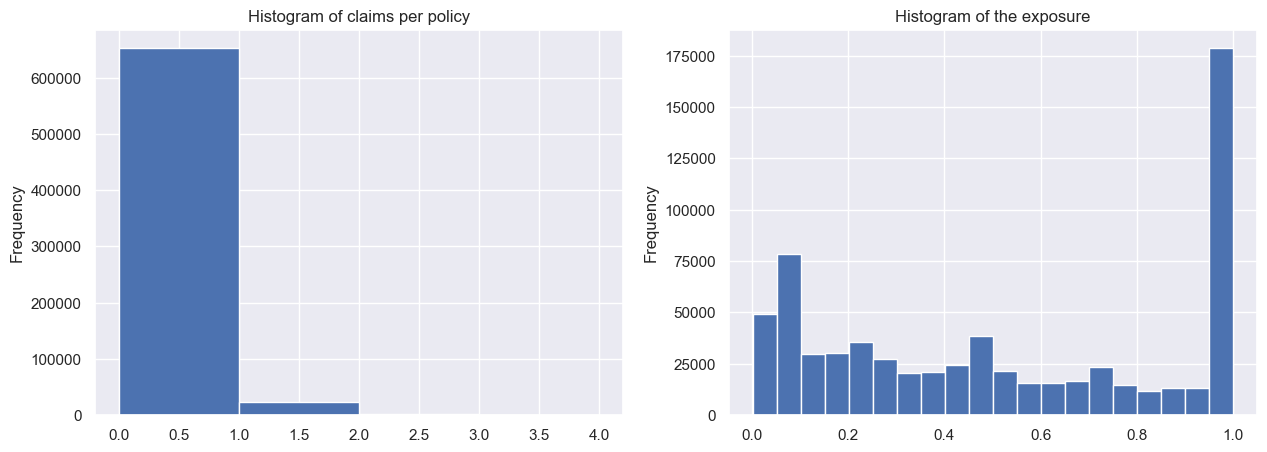

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax1.set_title("Histogram of claims per policy")
ax2.set_title("Histogram of the exposure")

df.ClaimNb.plot.hist(bins = 4, ax = ax1)
df.Exposure.plot.hist(bins = 20, ax = ax2)

In [17]:
df.ClaimNb.value_counts()

ClaimNb
0.0    653069
1.0     23571
2.0      1298
3.0        62
4.0        13
Name: count, dtype: int64

#### As expected, most policies are free of claims. We observe a significant proportion of policies with an exposure value of less than 0.5 and therefore expect a large difference between the exposure-weighted and the unweighted claims frequency. In addition we calculate the annualized claims frequency variable.

In [18]:
df["frequency"] = df["ClaimNb"] / df["Exposure"]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7132\2011171259.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_eda = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"]).agg(claim_frequency = pd.NamedAgg(column = "ClaimNb", aggfunc = sum),
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7132\2011171259.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_eda = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"]).agg(claim_frequency = pd.NamedAgg(column = "ClaimNb", aggfunc = sum),


Text(0.5, 0.98, 'Modified Claims Frequency')

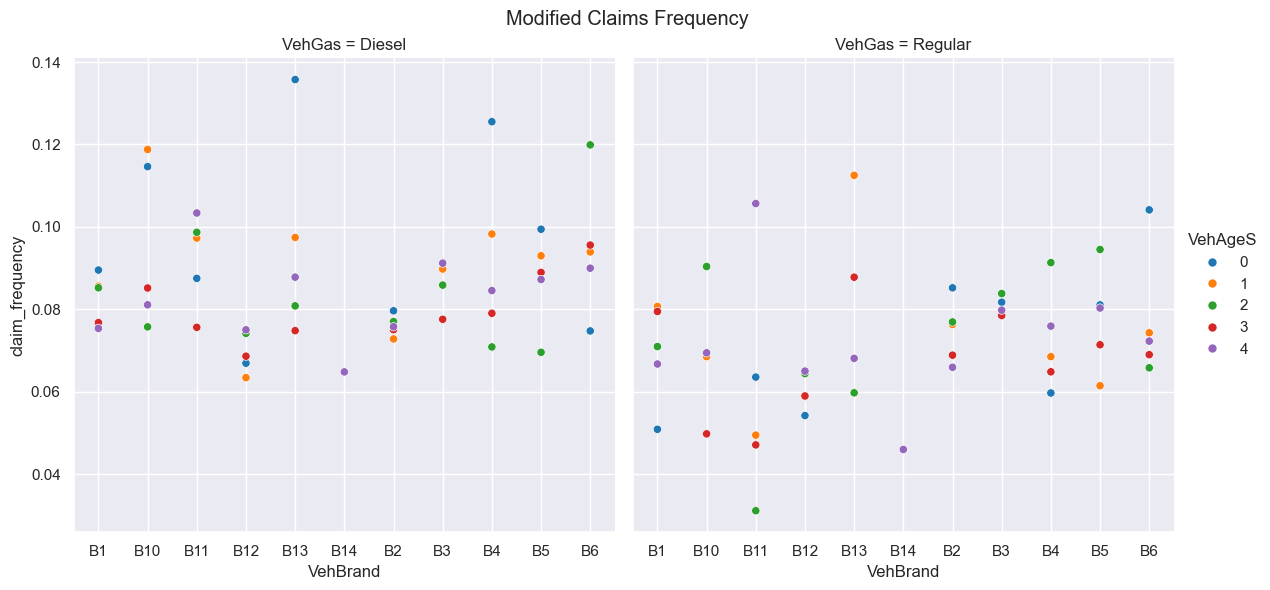

In [23]:
df_eda = df.copy()
df_eda["VehAgeS"] = np.minimum(4, df_eda.VehAge)
df_eda = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"]).agg(claim_frequency = pd.NamedAgg(column = "ClaimNb", aggfunc = sum),
expo = pd.NamedAgg(column = "Exposure", aggfunc = sum))

df_eda.claim_frequency = df_eda.claim_frequency / df_eda.expo

df_eda = df_eda.query("expo >= 100")

rp = sns.relplot(data = df_eda, x = "VehBrand", y = "claim_frequency", col = "VehGas", hue = "VehAgeS", palette = "tab10", kind = "scatter", height = 6)

rp.fig.subplots_adjust(top = 0.9)

rp.fig.suptitle("Modified Claims Frequency")